In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
from statsmodels.regression.linear_model import OLS

In [2]:
import librosa
import librosa.display as dp
import IPython.display as ipd

In [3]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

# Задача 1.2

Требуется:

1. Отобрать записи, соответствующие странам с минимум 30 респонеднтами в выборке
- Получить сумму zero-crossing по каждой из записей
- Провести ANOVA-анализ по аттрибутам родного языка, пола и возраста для уровня значимости 0.15. Дискретность признака zero-crossing игнорировать. Учитывать также межфакторное взаимодействие.

In [4]:
data = pd.read_csv('speakers_all.csv')
data

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN
5,43.0,41.0,"port-au-prince, haiti",haitian,haitian,male,1167,haiti,True,NaN,NaN,NaN
6,21.0,21.0,"port-au-prince, haiti",haitian,haitian,male,1168,haiti,True,NaN,NaN,NaN
7,54.0,51.0,"port-au-prince, haiti",haitian,haitian,female,1169,haiti,True,NaN,NaN,NaN
8,18.0,16.0,"ouanaminthe, haiti",haitian,haitian,female,1866,haiti,True,NaN,NaN,NaN
9,73.0,5.0,"pepeekeo, hawai'i, usa",hawai'i,hawai'i,male,1675,usa,True,NaN,NaN,NaN


Отоберем записи, соответствующие странам с минимум 30 респонеднтами в выборке.

Стоит отметить: есть данные, у которых не сохранились аудио файлы, поэтому соит их исключить из рассмотрения, поскольку мы не будем информацию о  велечине `zero_crossings` для этих спикеров. 

In [5]:
from collections import Counter
data_new = data[data['file_missing?'] == False]
d = Counter(list(data_new['country']))
little_country = dict(filter(lambda elem: elem[1] <= 30 , d.items()))
big_country = dict(filter(lambda elem: elem[1] >= 30 , d.items()))
l = list(little_country.keys())
print(list(big_country.keys()))
data_new = data_new[~data_new.country.isin(l)] 

data_new.head(5)

['ethiopia', 'saudi arabia', 'usa', 'uk', 'russia', 'china', 'germany', 'india', 'belgium', 'south korea', 'canada', 'australia', 'italy', 'poland', 'brazil', 'turkey']


,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
50,20.0,5.0,"addis ababa, ethiopia",amharic1,amharic,female,6,ethiopia,False,NaN,NaN,NaN
51,29.0,19.0,"gonder, ethiopia",amharic10,amharic,female,998,ethiopia,False,NaN,NaN,NaN
52,24.0,17.0,"addis ababa, ethiopia",amharic11,amharic,female,1129,ethiopia,False,NaN,NaN,NaN
53,26.0,15.0,"addis ababa, ethiopia",amharic12,amharic,female,1130,ethiopia,False,NaN,NaN,NaN
54,28.0,6.0,"addis ababa, ethiopia",amharic13,amharic,female,1131,ethiopia,False,NaN,NaN,NaN


/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


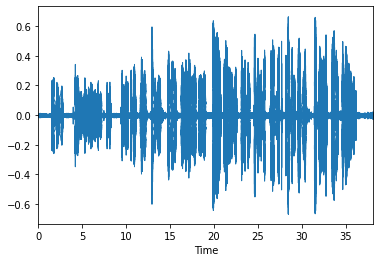

In [6]:
name = 'amharic1'
audio_path = './recordings/' + name +'.mp3'
x, sr = librosa.load(audio_path)
dp.waveplot(x, sr=sr)

In [7]:
fname = list(data_new['filename'])
zero_crossings = []
for name in fname :

    audio_path = './recordings/' + name +'.mp3'
    x, sr = librosa.load(audio_path)
    zcr = librosa.zero_crossings(x)
    zero_crossings.append(zcr.sum())

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/abdurakhmonsadiev/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread inst

Добавим колонку со значениями `zero_crossings`

In [8]:
data_new['zero_crossings'] = zero_crossings

### Трёхфакторный дисперсионный анализ

In [9]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [10]:
lm = ols('zero_crossings ~ age * C(native_language) * C(sex)', data=data_new).fit()
table_F = sm.stats.anova_lm(lm, typ=1)
table_F

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),55.0,2.736085e+11,4.974700e+09,6.971957,1.029247e-40
C(sex),1.0,1.183476e+10,1.183476e+10,16.586209,5.051896e-05
C(native_language):C(sex),55.0,9.003011e+10,1.636911e+09,2.294103,6.209921e-07
age,1.0,1.190734e+10,1.190734e+10,16.687929,4.792725e-05
age:C(native_language),55.0,6.663396e+10,1.211527e+09,1.697934,1.468139e-03
age:C(sex),1.0,1.231659e+08,1.231659e+08,0.172615,6.778958e-01
age:C(native_language):C(sex),55.0,3.819686e+10,6.944883e+08,0.973314,5.314636e-01
Residual,914.0,6.521664e+11,7.135300e+08,NaN,NaN


Определим значимые признаки

In [11]:
table_F[table_F['PR(>F)'] < 0.15]

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),55.0,2.736085e+11,4.974700e+09,6.971957,1.029247e-40
C(sex),1.0,1.183476e+10,1.183476e+10,16.586209,5.051896e-05
C(native_language):C(sex),55.0,9.003011e+10,1.636911e+09,2.294103,6.209921e-07
age,1.0,1.190734e+10,1.190734e+10,16.687929,4.792725e-05
age:C(native_language),55.0,6.663396e+10,1.211527e+09,1.697934,1.468139e-03


Как мы видим: возраст (`age`), пол (`sex`), родной язык (`native_language`) значимы, как и межфактроные взаимодействия (пол : родной язык) и (возрост: язык). 

Однако, я подозреваю, что, разбив спикеров на возрастные группы, можно получить более наглядный анализ.

Так и сделаем :-)

Теперь разобьем спикеров по возрастным группам: 
- `young` определяется как ( `age` $\leq$ 24 )
- `middle` определяется как (25 $\leq$ `age` $\leq$ 39)
- `old` определяется (40 $\leq$ `age` )

In [13]:
age_group = []
for i in data_new['age']:
    if i <= 24:
        age_group.append('young')
    elif (i >= 25) & (i <= 39):
        age_group.append('middle')
    elif i >= 40:
        age_group.append('old')
        
data_new['age_group'] = age_group 

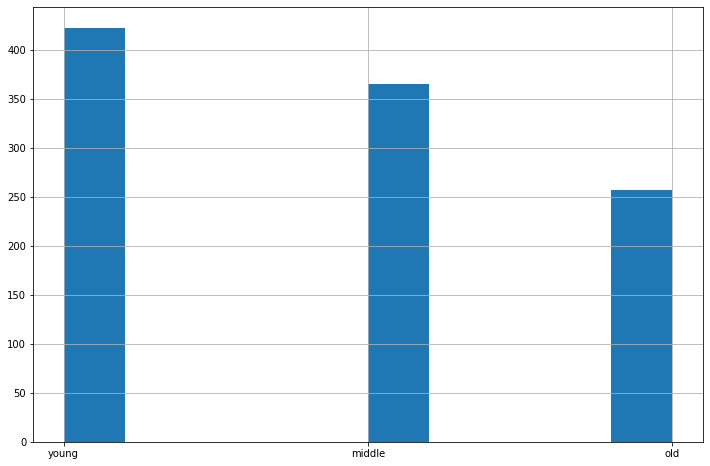

In [14]:
plt.figure(figsize=(12, 8))
data_new['age_group'].hist()

Снова проведем трехфакторный дисперсионный анализ

In [15]:
lm = ols('zero_crossings ~ C(age_group) * C(native_language) * C(sex)', data=data_new).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(age_group),2.0,1.378560e+10,6.892801e+09,9.627279,7.299040e-05
C(native_language),55.0,2.769801e+11,5.036001e+09,7.033859,5.383921e-41
C(sex),1.0,1.128203e+10,1.128203e+10,15.757786,7.776109e-05
C(age_group):C(native_language),110.0,1.320516e+11,1.200469e+09,1.676713,4.778367e-05
C(age_group):C(sex),2.0,1.554293e+09,7.771463e+08,1.085452,3.381933e-01
C(native_language):C(sex),55.0,4.138925e+10,7.525319e+08,1.051073,3.771303e-01
C(age_group):C(native_language):C(sex),110.0,6.760307e+10,6.145733e+08,0.858384,8.436545e-01
Residual,895.0,6.407893e+11,7.159657e+08,NaN,NaN


Выделим значимые признаки

In [16]:
table[table['PR(>F)'] < 0.15]

,df,sum_sq,mean_sq,F,PR(>F)
C(age_group),2.0,1.378560e+10,6.892801e+09,9.627279,7.299040e-05
C(native_language),55.0,2.769801e+11,5.036001e+09,7.033859,5.383921e-41
C(sex),1.0,1.128203e+10,1.128203e+10,15.757786,7.776109e-05
C(age_group):C(native_language),110.0,1.320516e+11,1.200469e+09,1.676713,4.778367e-05


Как мы видим: возрастная группа (`age`), пол (`sex`), родной язык (`native_language`) значимы, как и межфактроные взаимодействия (возростная группа : родной язык). Остальное не значимо.

Проведем двухфакторный дисперсионный анализ для возрастных групп

###  Двухфакторный дисперсионный анализ для людей  группы `old`

In [17]:
data_old = data_new[data_new['age_group'] == 'middle'] 
lm = ols('zero_crossings ~ C(native_language) * C(sex)', data=data_old).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),35.0,3.965809e+10,1.133088e+09,1.662157,0.013275
C(sex),1.0,7.508926e+09,7.508926e+09,11.015044,0.001011
C(native_language):C(sex),35.0,2.025644e+10,5.787553e+08,0.848992,0.714508
Residual,312.0,2.126896e+11,6.816973e+08,NaN,NaN


In [18]:
table[table['PR(>F)'] < 0.15]

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),35.0,3.965809e+10,1.133088e+09,1.662157,0.013275
C(sex),1.0,7.508926e+09,7.508926e+09,11.015044,0.001011


 Все признаки значимы, но не их межфакторное взамодействие

['amharic', 'arabic', 'cantonese', 'english', 'german', 'hindi', 'italian', 'korean', 'mandarin', 'polish', 'portuguese', 'russian', 'turkish']


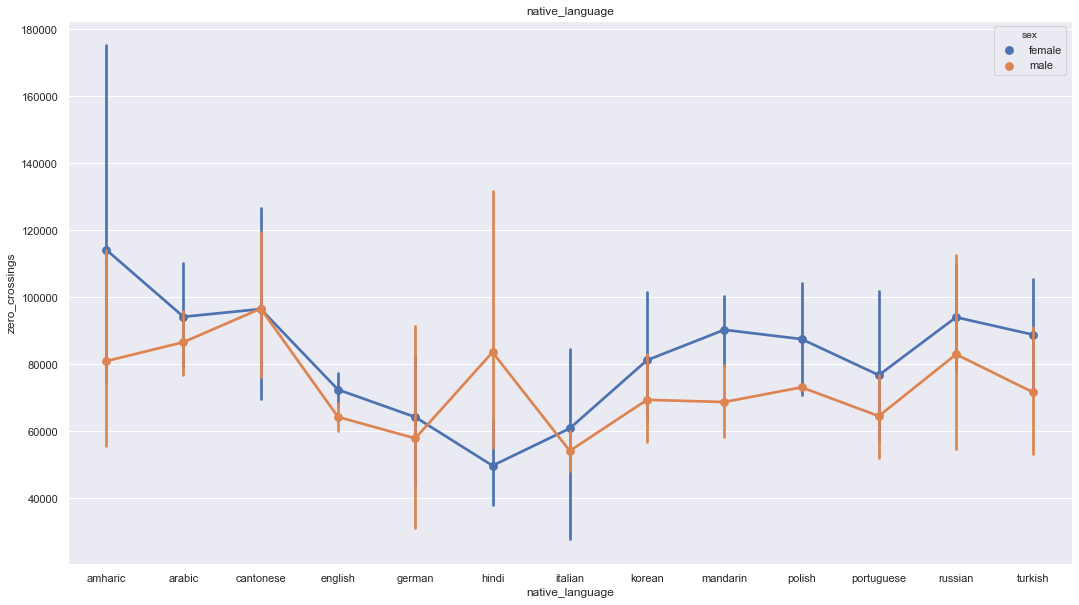

In [23]:
g = Counter(list(data_old['native_language']))
little_nat = dict(filter(lambda elem: elem[1] <= 5 , g.items()))
big_nat = dict(filter(lambda elem: elem[1] >=  , g.items()))
l = list(little_nat.keys())
print(list(big_nat.keys()))
data_old_nav = data_old[~data_old.native_language.isin(l)] 

plt.figure(figsize = (18, 10))
plt.title('native_language')
sns.set(rc = {'figure.figsize': (18, 16)})
sns.pointplot(x = 'native_language', y = 'zero_crossings', data=data_old_nav, hue='sex', rc = {'figure.figsize': (18, 16)})


По графику видно, что у пожилых женщин и мужчин, кому контенизийский является родным языком, значение `zero_crossings`не сильно отличается. Что не скажешь в случае пожилых мужчин и женщин, кому польский, или португальский, или  мандаринский, или русский, или амхарский, или корейский являются родным языком,  значение `zero_crossings` меньше для пожилых женщин в среднем. А в случае пожилых мужчин, для которых хинди родной язык,  значение `zero_crossings` больше чем пожилых женщин в среднем.

###  Двухфакторный дисперсионный анализ для группы людей средних лет `age`

In [25]:
data_middle = data_new[data_new['age_group'] == 'middle'] 
lm = ols('zero_crossings ~ C(native_language) * C(sex)', data=data_middle).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),35.0,3.965809e+10,1.133088e+09,1.662157,0.013275
C(sex),1.0,7.508926e+09,7.508926e+09,11.015044,0.001011
C(native_language):C(sex),35.0,2.025644e+10,5.787553e+08,0.848992,0.714508
Residual,312.0,2.126896e+11,6.816973e+08,NaN,NaN


In [26]:
table[table['PR(>F)'] < 0.15]

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),35.0,3.965809e+10,1.133088e+09,1.662157,0.013275
C(sex),1.0,7.508926e+09,7.508926e+09,11.015044,0.001011


 Все признаки значимы, но не их межфакторное взамодействие.

['amharic', 'arabic', 'cantonese', 'english', 'german', 'hindi', 'italian', 'korean', 'mandarin', 'polish', 'portuguese', 'russian', 'turkish']


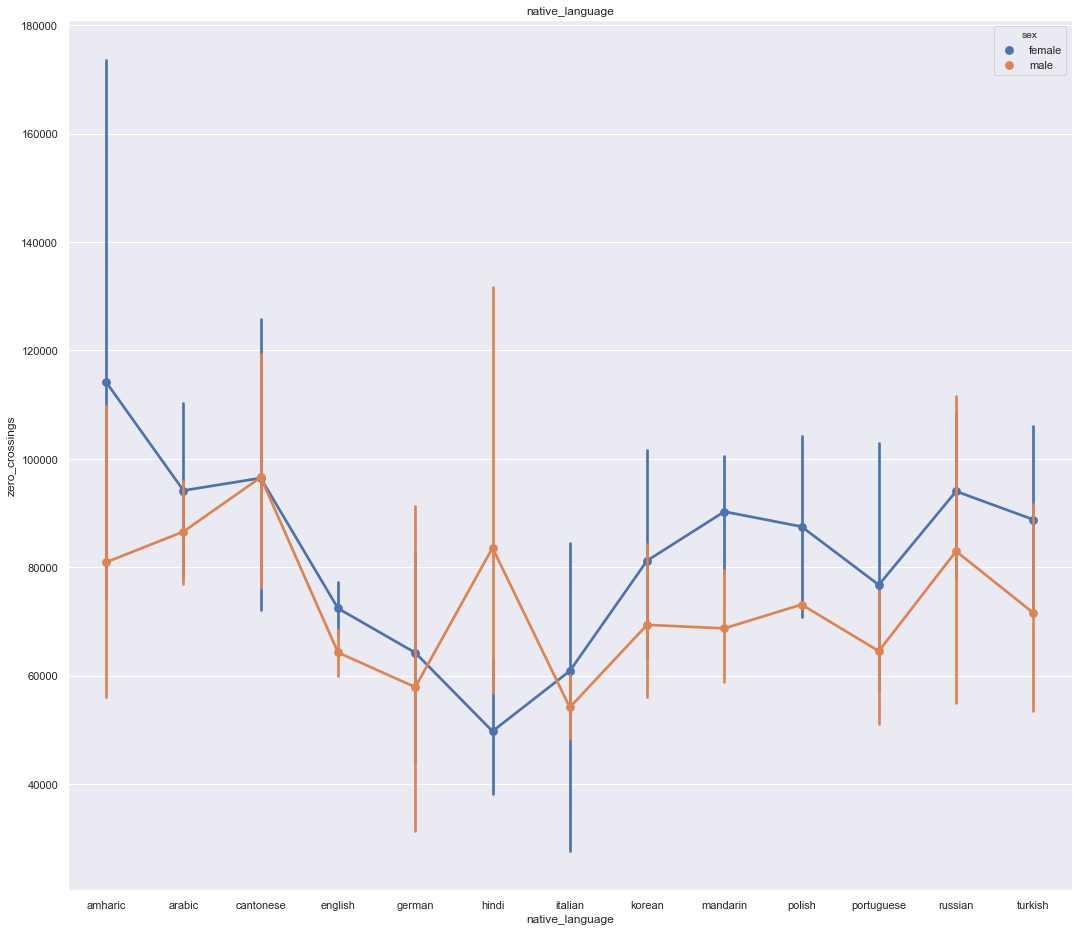

In [27]:
g = Counter(list(data_middle['native_language']))
little_nat = dict(filter(lambda elem: elem[1] <= 4 , g.items()))
big_nat = dict(filter(lambda elem: elem[1] >= 4 , g.items()))
l = list(little_nat.keys())
print(list(big_nat.keys()))
data_middle_nav = data_middle[~data_middle.native_language.isin(l)] 

plt.title('native_language')
sns.set(rc = {'figure.figsize': (18, 16)})
sns.pointplot(x = 'native_language', y = 'zero_crossings', data=data_middle_nav, hue='sex', rc = {'figure.figsize': (18, 16)})



По графику видно, что у женщин и мужчин средних лет, кому кантонезийский является родным языком, значение `zero_crossings`не сильно отличается. Что не скажешь в случае  мужчин и женщин средних лет, кому амхарский, или польский, или  мандаринский, или русский, или турецкий, или корейский являются родным языком,  значение `zero_crossings` больше для женщин в среднем. А в случае мужчин средних лет, для которых хинди родной язык,  значение `zero_crossings` больше чем у женщин в среднем.

###  Двухфакторный дисперсионный анализ для группы молодых людей `age`

In [28]:
data_young = data_new[data_new['age_group'] == 'young'] 
lm = ols('zero_crossings ~ C(native_language) * C(sex)', data=data_young).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),34.0,6.158353e+10,1.811280e+09,2.400436,0.000037
C(sex),1.0,6.719103e+08,6.719103e+08,0.890463,0.345968
C(native_language):C(sex),34.0,3.401721e+10,1.000506e+09,1.325941,0.110224
Residual,370.0,2.791883e+11,7.545630e+08,NaN,NaN


In [29]:
table[table['PR(>F)'] < 0.15]

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),34.0,6.158353e+10,1.811280e+09,2.400436,0.000037
C(native_language):C(sex),34.0,3.401721e+10,1.000506e+09,1.325941,0.110224


 Все признаки значимы. Все признаки значимы, но не их межфакторное взамодействие.
 
Рассмотрим случай, когда носителей определенного языка больше 10.

['arabic', 'cantonese', 'dutch', 'english', 'german', 'italian', 'korean', 'mandarin', 'polish', 'portuguese', 'turkish']


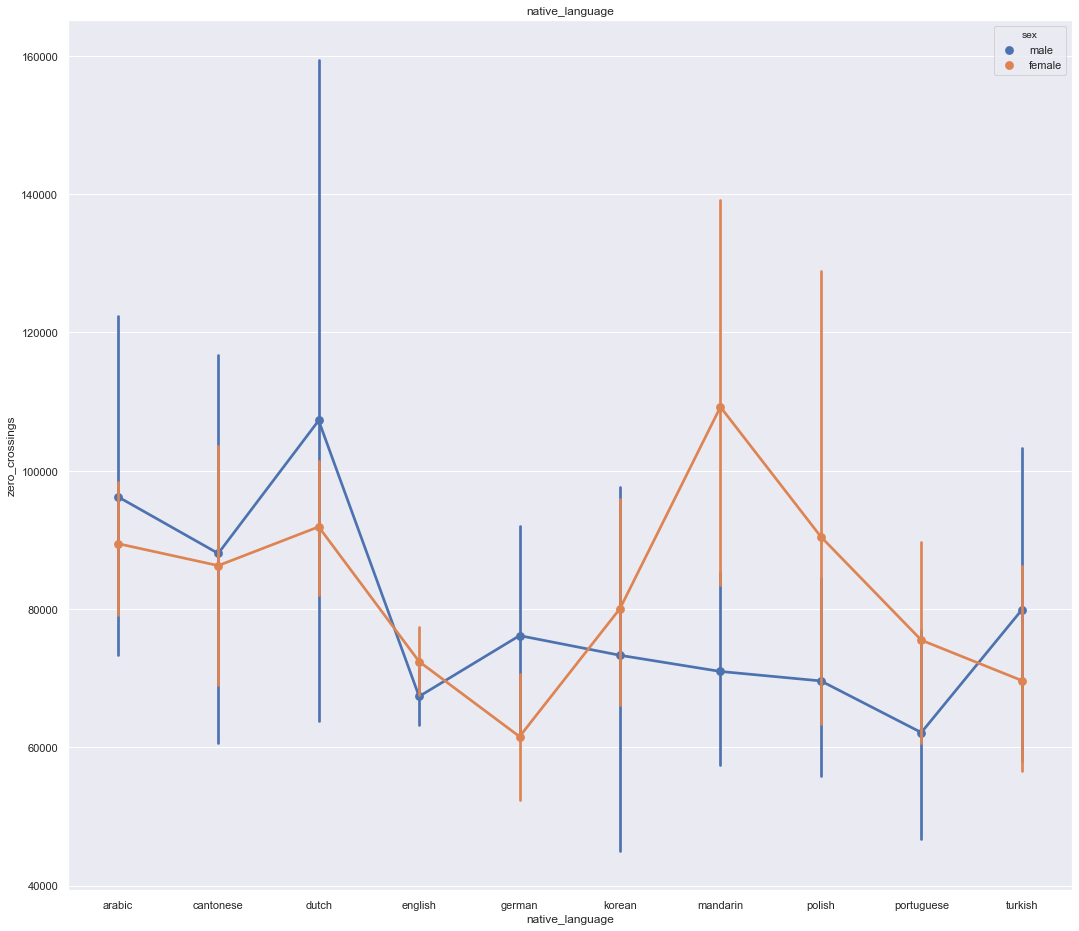

In [30]:
g = Counter(list(data_young['native_language']))
little_nat = dict(filter(lambda elem: elem[1] <= 10 , g.items()))
big_nat = dict(filter(lambda elem: elem[1] >= 10 , g.items()))
l = list(little_nat.keys())
print(list(big_nat.keys()))
data_young_nav = data_young[~data_young.native_language.isin(l)] 

plt.title('native_language')
sns.pointplot(x = 'native_language', y = 'zero_crossings', data=data_young_nav, hue='sex', rc = {'figure.figsize': (18, 16)})


По графику видно, что у молодых женщин и мужчин, кому кантонезийский являются родным языком, значение `zero_crossings`не сильно отличается. Что не скажешь в случае молодых мужчин и женщин, кому польский, или  мандаринский, значение `zero_crossings` больше для молодых женщин. В случае голадского, немецкого, турецкого ситуация противоположная: значение `zero_crossings` больше для молодых мужчин.


###  Двухфакторный анализ по родному языку `native_language`

Проведем двухфакторный анализ, когда родной язык часто встречаем.

In [31]:
g = Counter(list(data_new['native_language']))
little_nat = dict(filter(lambda elem: elem[1] <= 10 , g.items()))
big_nat = dict(filter(lambda elem: elem[1] >= 10 , g.items()))
l = list(little_nat.keys())
print(list(big_nat.keys()))
data_lan = data_new[~data_new.native_language.isin(l)] 

['amharic', 'arabic', 'cantonese', 'dutch', 'english', 'french', 'german', 'hindi', 'italian', 'korean', 'mandarin', 'polish', 'portuguese', 'russian', 'turkish']


In [32]:
for language in big_nat:
    df = data_lan[data_lan['native_language'] == language] 
    lm = ols('zero_crossings ~ C(age_group) * C(sex)', data=df).fit()
    table = sm.stats.anova_lm(lm, typ=1)
    print(language)
    print(table)
    print('-'*100)
    print(table[table['PR(>F)'] < 0.15])
    print('#'*100)

amharic
                       df        sum_sq       mean_sq         F    PR(>F)
C(age_group)          2.0  4.093208e+08  2.046604e+08  0.060315  0.941711
C(sex)                1.0  5.189998e+07  5.189998e+07  0.015295  0.903331
C(age_group):C(sex)   2.0  1.139081e+10  5.695403e+09  1.678489  0.222115
Residual             14.0  4.750440e+10  3.393172e+09       NaN       NaN
----------------------------------------------------------------------------------------------------
Empty DataFrame
Columns: [df, sum_sq, mean_sq, F, PR(>F)]
Index: []
####################################################################################################
arabic
                       df        sum_sq       mean_sq         F    PR(>F)
C(age_group)          2.0  1.361056e+10  6.805279e+09  5.049674  0.012638
C(sex)                1.0  5.728411e+07  5.728411e+07  0.042506  0.838006
C(age_group):C(sex)   2.0  1.293238e+09  6.466189e+08  0.479806  0.623423
Residual             31.0  4.177768e+10  1.347667

- Для людей, у которых арабский, или корейский или русский являются родными языками, для значения `zero_crossings` значимым признаком является возрастная группа.
- В случае  французского, для значения `zero_crossings` значимым признаком является пол человека . 
- В случае английского для значения `zero_crossings` значимым признаками являются как пол человека, так и возрастная группа.
- В случае мандаринского важными оказались признаками пол и межфакторное взаимодествие.

In [33]:
mc = MultiComparison(data_new['zero_crossings'], data_new['age_group'])
result = mc.tukeyhsd()
print(result)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj     lower      upper    reject
-------------------------------------------------------------
middle    old  9321.8295  0.001   3379.2756 15264.3835   True
middle  young  2207.5142 0.5752  -3006.0824  7421.1108  False
   old  young -7114.3153 0.0109 -12886.0804 -1342.5503   True
-------------------------------------------------------------


In [34]:
mc = MultiComparison(data_new['zero_crossings'], data_new['sex'])
result = mc.tukeyhsd()
print(result)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
female   male -8286.2343 0.001 -12053.7467 -4518.7219   True
------------------------------------------------------------


По всей выборке тенденция такая: 

- у мужчин значение  `zero_crossings`  выше, чем у женщин
- у пожилых людей меньше значение   `zero_crossings`, чем у других возрастных групп

####  Однофакторный дисперсионный анализ для группы молодых мужчин `age`

In [36]:
data_young = data_new[data_new['age_group'] == 'young'] 
data_young_male = data_young[data_young['sex'] == 'male']
lm = ols('zero_crossings ~ C(native_language) ', data = data_young_male).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),26.0,4.747179e+10,1.825838e+09,1.990192,0.004497
Residual,199.0,1.825662e+11,9.174183e+08,NaN,NaN


Конечно, признак значим.

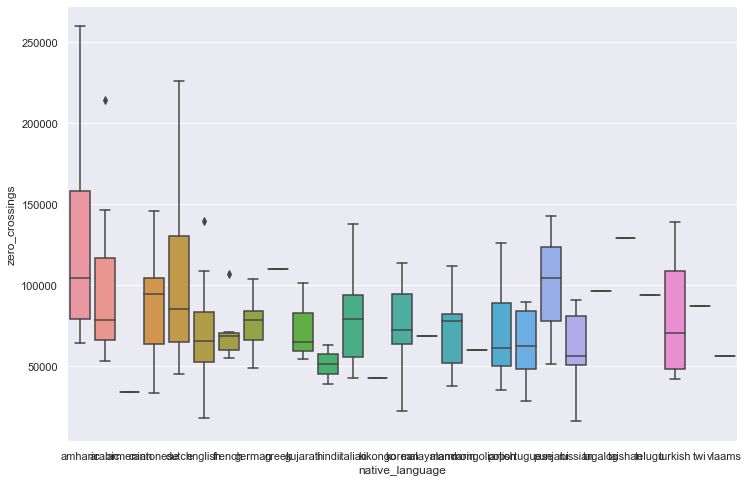

In [37]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='native_language', y='zero_crossings', data = data_young_male)

Для презентабельности: выделим часто всречаемые языки

['arabic', 'cantonese', 'dutch', 'english', 'french', 'german', 'italian', 'korean', 'mandarin', 'polish', 'portuguese', 'russian', 'turkish']


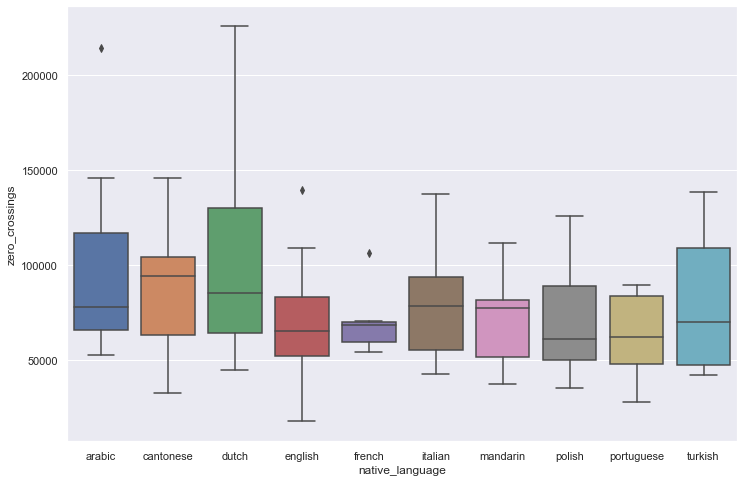

In [38]:
g = Counter(list(data_young_male['native_language']))
little_nat = dict(filter(lambda elem: elem[1] <= 5 , g.items()))
big_nat = dict(filter(lambda elem: elem[1] >= 5 , g.items()))
l = list(little_nat.keys())
print(list(big_nat.keys()))
data_lan = data_young_male[~data_young_male.native_language.isin(l)] 

plt.figure(figsize=(12, 8))
sns.boxplot(x = 'native_language', y = 'zero_crossings', data = data_lan)

In [39]:
mc = MultiComparison(data_young_male['zero_crossings'], data_young_male['native_language'])
result = mc.tukeyhsd()
print(result)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
  group1     group2     meandiff  p-adj     lower        upper    reject
------------------------------------------------------------------------
   amharic     arabic -36751.5833    0.9 -102344.8838  28841.7171  False
   amharic   armenian   -99081.25 0.4083 -226102.1301  27939.6301  False
   amharic  cantonese -44963.4167  0.826  -118298.956  28372.1226  False
   amharic      dutch   -25732.25    0.9  -99067.7893  47603.2893  False
   amharic    english -65648.5682 0.0086 -123477.6369  -7819.4995   True
   amharic     french   -62001.25 0.2441 -135336.7893  11334.2893  False
   amharic     german   -56852.05 0.5001  -133064.578   19360.478  False
   amharic      greek   -23265.25    0.9 -150286.1301 103755.6301  False
   amharic   gujarati   -59735.25 0.6413 -146507.0303  27036.5303  False
   amharic      hindi   -81923.75 0.2722 -180313.7006  16466.2006  False
   amharic    italian  -51758.625 0.5051 -121330.82

Изучив таблицу, можно прийти к следующим заключениям о значении `zero_crossings`:

- У амхарских молодых мужчин значение `zero_crossings` меньше чем  `zero_crossings` английских и португальских.


####  Однофакторный дисперсионный анализ для группы молодых женщин `age`

In [40]:
data_young = data_new[data_new['age_group'] == 'young'] 
data_young_female = data_young[data_young['sex'] == 'female']
lm = ols('zero_crossings ~ C(native_language) ', data = data_young_female).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),25.0,3.229371e+10,1.291748e+09,2.286113,0.001035
Residual,171.0,9.662205e+10,5.650412e+08,NaN,NaN


Конечно, признак значим.

['arabic', 'cantonese', 'dutch', 'english', 'german', 'korean', 'mandarin', 'portuguese', 'turkish']


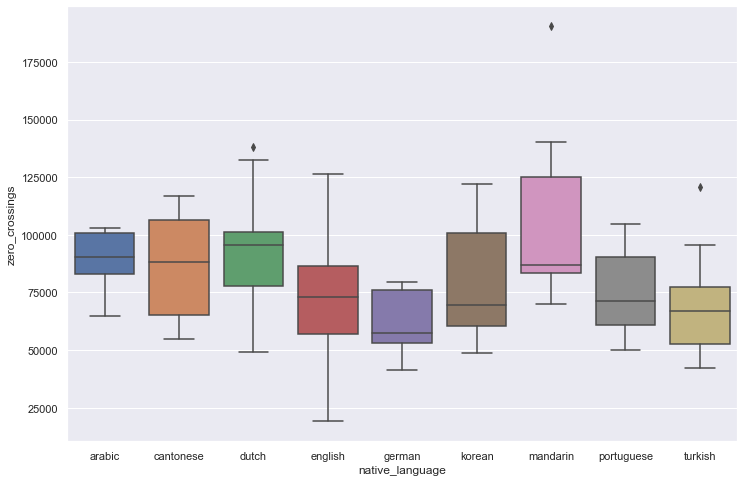

In [41]:
g = Counter(list(data_young_female['native_language']))
little_nat = dict(filter(lambda elem: elem[1] <= 5 , g.items()))
big_nat = dict(filter(lambda elem: elem[1] >= 5 , g.items()))
l = list(little_nat.keys())
print(list(big_nat.keys()))
data_lan = data_young_female[~data_young_female.native_language.isin(l)] 

plt.figure(figsize=(12, 8))
sns.boxplot(x = 'native_language', y = 'zero_crossings', data = data_lan)

In [42]:
mc = MultiComparison(data_young_female['zero_crossings'], data_young_female['native_language'])
result = mc.tukeyhsd()
print(result)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
  group1     group2     meandiff  p-adj     lower        upper    reject
------------------------------------------------------------------------
   amharic     arabic   9484.0357    0.9  -46240.1526   65208.224  False
   amharic  cantonese   6304.1786    0.9  -49420.0097  62028.3669  False
   amharic      dutch     11915.3    0.9  -36780.0007  60610.6007  False
   amharic    english  -7576.8343    0.9  -53017.3132  37863.6446  False
   amharic     french   -28442.25    0.9 -105436.2807  48551.7807  False
   amharic     german    -18432.0    0.9  -72875.0012  36011.0012  False
   amharic      greek    14449.75    0.9  -84949.1163 113848.6163  False
   amharic      hindi -11168.5833    0.9  -79070.9359  56733.7692  False
   amharic    italian    -3721.25    0.9  -80715.2807  73272.7807  False
   amharic      khmer    22602.75    0.9  -76796.1163 122001.6163  False
   amharic     korean     85.1136    0.9  -51824.25

Изучив таблицу, можно прийти к следующим заключениям о значении `zero_crossings`:

- У английских молодых женщин значении `zero_crossings`  больше, чем у китайских молодых женщин.
- У немецских молодых женщин значении `zero_crossings`  больше, чем у китайских молодых женщин.

####  Однофакторный дисперсионный анализ для группы  женщин средних лет 

In [43]:
data_middle = data_new[data_new['age_group'] == 'middle'] 
data_middle_female = data_middle[data_middle['sex'] == 'female']
lm = ols('zero_crossings ~ C(native_language) ', data = data_middle_female).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),25.0,3.168343e+10,1.267337e+09,1.627764,0.03932
Residual,154.0,1.199007e+11,7.785757e+08,NaN,NaN


Конечно, признак значим.

In [44]:
mc = MultiComparison(data_middle_female['zero_crossings'], data_middle_female['native_language'])
result = mc.tukeyhsd()
print(result)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
  group1     group2     meandiff  p-adj     lower        upper    reject
------------------------------------------------------------------------
   amharic     arabic -19983.7333    0.9    -83293.89  43326.4233  False
   amharic  cantonese -17685.5429    0.9  -78905.6766  43534.5908  False
   amharic    english -41729.4909 0.2012  -89981.3704   6522.3886  False
   amharic     french    -48971.4    0.9 -163503.7827  65560.9827  False
   amharic     german    -49915.4 0.7121 -126270.3218  26439.5218  False
   amharic   gujarati    -38771.9    0.9 -126247.4522  48703.6522  False
   amharic      hindi -64411.7333 0.2415 -140766.6552  11943.1885  False
   amharic    italian    -53289.4 0.4522 -123425.8742  16847.0742  False
   amharic    kannada    -55336.4    0.9 -169868.7827  59195.9827  False
   amharic    konkani    -53143.4    0.9 -167675.7827  61388.9827  False
   amharic     korean -32941.8286    0.9  -94161.96

####  Однофакторный дисперсионный анализ для группы мужчин средних лет 

In [45]:
data_middle = data_new[data_new['age_group'] == 'middle'] 
data_middle_male = data_middle[data_middle['sex'] == 'male']
lm = ols('zero_crossings ~ C(native_language) ', data = data_middle_male).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),26.0,1.470477e+10,5.655680e+08,0.963043,0.521131
Residual,158.0,9.278891e+10,5.872716e+08,NaN,NaN


Для данной возрастной группы мужчин признак не значим.

In [46]:
mc = MultiComparison(data_middle_male['zero_crossings'], data_middle_male['native_language'])
result = mc.tukeyhsd()
print(result)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
  group1     group2     meandiff  p-adj     lower        upper    reject
------------------------------------------------------------------------
   amharic     arabic   5649.1333    0.9  -45242.5381  56540.8047  False
   amharic    bengali -25510.5333    0.9  -92143.3723  41122.3056  False
   amharic  cantonese  15664.4667    0.9  -50968.3723  82297.3056  False
   amharic      dutch     -5825.2    0.9 -105774.4585  94124.0585  False
   amharic    english -16654.6023    0.9  -58614.8689  25305.6643  False
   amharic    finnish     -2765.2    0.9 -102714.4585  97184.0585  False
   amharic     german   -23044.95    0.9  -84251.1209  38161.2209  False
   amharic   gujarati    -22631.2    0.9 -122580.4585  77318.0585  False
   amharic    hadiyya     -6316.2    0.9 -106265.4585  93633.0585  False
   amharic      hindi      2649.3    0.9  -58556.8709  63855.4709  False
   amharic    italian    -26779.2    0.9  -87985.37

####  Однофакторный дисперсионный анализ для группы мужчин пожилых 

In [47]:
data_old = data_new[data_new['age_group'] == 'old'] 
data_old_male = data_middle[data_middle['sex'] == 'male']
lm = ols('zero_crossings ~ C(native_language) ', data = data_old_male).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),26.0,1.470477e+10,5.655680e+08,0.963043,0.521131
Residual,158.0,9.278891e+10,5.872716e+08,NaN,NaN


Для данной возрастной группы мужчин признак не значим.

In [48]:
mc = MultiComparison(data_old_male['zero_crossings'], data_old_male['native_language'])
result = mc.tukeyhsd()
print(result)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
  group1     group2     meandiff  p-adj     lower        upper    reject
------------------------------------------------------------------------
   amharic     arabic   5649.1333    0.9  -45242.5381  56540.8047  False
   amharic    bengali -25510.5333    0.9  -92143.3723  41122.3056  False
   amharic  cantonese  15664.4667    0.9  -50968.3723  82297.3056  False
   amharic      dutch     -5825.2    0.9 -105774.4585  94124.0585  False
   amharic    english -16654.6023    0.9  -58614.8689  25305.6643  False
   amharic    finnish     -2765.2    0.9 -102714.4585  97184.0585  False
   amharic     german   -23044.95    0.9  -84251.1209  38161.2209  False
   amharic   gujarati    -22631.2    0.9 -122580.4585  77318.0585  False
   amharic    hadiyya     -6316.2    0.9 -106265.4585  93633.0585  False
   amharic      hindi      2649.3    0.9  -58556.8709  63855.4709  False
   amharic    italian    -26779.2    0.9  -87985.37

####  Однофакторный дисперсионный анализ для группы женщин пожилых 

In [49]:
data_old = data_new[data_new['age_group'] == 'old'] 
data_old_female = data_middle[data_middle['sex'] == 'female']
lm = ols('zero_crossings ~ C(native_language) ', data = data_old_female).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),25.0,3.168343e+10,1.267337e+09,1.627764,0.03932
Residual,154.0,1.199007e+11,7.785757e+08,NaN,NaN


Признак значим

In [50]:
mc = MultiComparison(data_old_female['zero_crossings'], data_old_female['native_language'])
result = mc.tukeyhsd()
print(result)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
  group1     group2     meandiff  p-adj     lower        upper    reject
------------------------------------------------------------------------
   amharic     arabic -19983.7333    0.9    -83293.89  43326.4233  False
   amharic  cantonese -17685.5429    0.9  -78905.6766  43534.5908  False
   amharic    english -41729.4909 0.2012  -89981.3704   6522.3886  False
   amharic     french    -48971.4    0.9 -163503.7827  65560.9827  False
   amharic     german    -49915.4 0.7121 -126270.3218  26439.5218  False
   amharic   gujarati    -38771.9    0.9 -126247.4522  48703.6522  False
   amharic      hindi -64411.7333 0.2415 -140766.6552  11943.1885  False
   amharic    italian    -53289.4 0.4522 -123425.8742  16847.0742  False
   amharic    kannada    -55336.4    0.9 -169868.7827  59195.9827  False
   amharic    konkani    -53143.4    0.9 -167675.7827  61388.9827  False
   amharic     korean -32941.8286    0.9  -94161.96

### Вывод:

- у мужчин значение  `zero_crossings`  выше, чем у женщин.

- у пожилых людей меньше значение   `zero_crossings`, чем у других возрастных групп.

- Для людей, у которых арабский, или корейский или русский являются родными языками, для значения `zero_crossings` значимым признаком является возрастная группа.

- В случае  французского, для значения `zero_crossings` значимым признаком является пол человека. 

- В случае английского для значения `zero_crossings` значимым признаками являются как пол человека, так и возрастная группа.

- В случае мандаринского важными оказались признаками пол и межфакторное взаимодествие.

- У английских молодых женщин значении `zero_crossings`  больше, чем у китайских молодых женщин.

- У немецских молодых женщин значении `zero_crossings`  больше, чем у китайских молодых женщин.

- У амхарских молодых мужчин значение `zero_crossings` меньше чем  `zero_crossings` английских и португальских.

- Для мужчин старшего поколения (`middle`, `old`) родной язык не значим для значения `zero_crossings`.